In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import pandas as pd
import healpy as hp
import time
import warnings
from pixell import reproject
from classy import Class
import s1 

In [2]:
def gabor(freq,sigma,theta):
    
    arg=-(theta**2)/(2*sigma*sigma) + 1.j * freq*theta
    
    g=np.exp(arg)
    g/=2*np.pi*sigma*sigma
    return g

In [3]:
def morlet(f,sigma,theta,lmax):
    wv=gabor(f,sigma,theta)
    wvm=gabor(0,sigma, theta)
    B=hp.beam2bl(wv,theta,lmax)[0]/hp.beam2bl(wvm,theta,lmax)[0]
    mor=wv-B*wvm
    return mor

<font size="5">Scattering Transform</font>

Implementing the transform.

Wavelet description:

$\sigma = 0.8 \times 2^j$

$k = \frac{3\pi}{4 \times 2^j}$

Transform steps

Map = $I_0$

$\psi_1$ = set of filters corresponding to $j_1$

$\psi_2$ = set of filters corresponding to $j_2$

$\phi_1$ = Gaussian filter correspoding to $j_1$

$\phi_2$ = Gaussian filter correspoding to $j_2$

1. $I_1 = |I_0 \star \psi_1|$
2. $S_1 = \langle I_1 \star \phi_1 \rangle$
3. $I_2 = |I_1 \star \psi_2|$
4. $S_2 = \langle I_2 \star \phi_2 \rangle$


In [39]:
def compS1 (hmap, resol,jmin, jmax, lmax, nside, theta_bin ):

    theta=np.linspace(0,np.pi,theta_bin)

    mapalm=hp.map2alm(hmap,lmax,use_pixel_weights=True)
    jarray = np.arange(jmin,jmax)
    S1=np.zeros((len(jarray)))

    i1=[]

    for j1 in jarray:
        print(j1)
        sigma1 = (0.8*resol*2**j1) # multiplied by resolution in radians
        freq1=(3.0*np.pi) /(4.0*resol*2**j1) #divided by resolution in radians
        
        #filter 1
        mor=morlet(freq1,sigma1,theta,lmax) 
        mor_l=hp.beam2bl(mor.real,theta,lmax) 
        

        #convolving the map with filter 1
        
        nalm=hp.almxfl(mapalm,mor_l)
        I1=hp.alm2map(nalm,nside,lmax)
        

        #modulus
        I1=np.abs(I1)

        i1.append(I1)

        #Gaussian filter for S1
        phi1=gabor(0,sigma1, theta)
        gab_l=hp.beam2bl(phi1.real,theta,lmax)
        
        #Convolving with gaussian filter to get S1
        I1alm=hp.map2alm(I1,lmax=lmax,use_pixel_weights=True)
        
        nI1alm=hp.almxfl(I1alm,gab_l)
        
        S1map=hp.alm2map(nI1alm,nside,lmax)
        
        #Averaging the entire map
        S1[j1-jmin]=np.mean(S1map)
        
    return S1

In [2]:
cmap = plt.cm.RdBu

In [3]:
c__256 = 'C0'
c__512 = 'C1'
c_1024 = 'C2'
c_proj = 'C2'
c_fgen = 'C3'

In [4]:
try:
    cosmo.struct_cleanup()
except:
    pass
cosmo = Class()
cosmo.set({
    'output': 'tCl lCl', 
    'modes': 's',
    'omega_b': 0.022383, 
    'omega_cdm': 0.12011, 
    '100*theta_s': 1.041085, 
    'tau_reio': 0.0543, 
    'A_s': np.exp(3.0448)*1e-10, 
    'n_s': 0.96605, 
    'm_ncdm': 0.06, 
    'N_ncdm': 1, 
    'N_ur': 2.0328, 
    'lensing': 'yes', 
    'l_max_scalars': 20000
})

True

In [5]:
%%time
cosmo.compute()

CPU times: user 1min 29s, sys: 3.02 s, total: 1min 32s
Wall time: 1min 33s


In [6]:
ell = cosmo.lensed_cl()['ell']
lmax = ell[-1]
norm = ell * (ell+1) / (2*np.pi)
cl_cmb = cosmo.lensed_cl()['tt'] * cosmo.T_cmb()**2 / 1e-6**2

In [8]:
def power_axes(ax1, ax2):
    ax1.set_xlabel("$\ell$")
    ax2.set_xlabel("$\ell$")
    ax1.set_ylabel("$C_\ell\ \ell (\ell+1) / 2\pi\ /\ \mu\mathrm{K^2}$")
    ax2.set_ylabel("$C_\ell\ \ell (\ell+1) / 2\pi\ /\ \mu\mathrm{K^2}$")
    ax1.set_xlim(-100, 3000)
    ax2.set_xlim(1, 10000)

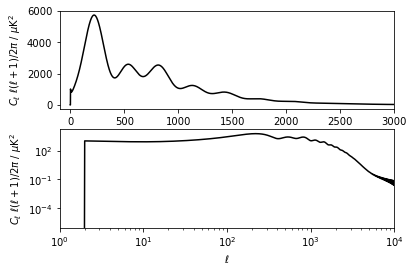

In [9]:
fig = plt.figure()
ax1 = plt.subplot(211)
ax1.plot(ell, cl_cmb*norm, c='k',   label="CMB power spectrum (from CLASS with P18 best-fit parameters)")
#ax1.plot(ell, cl_pwl*norm, c='0.5', label="custom power-laws power spectrum")
#ax1.legend(handlelength=0, labelcolor='linecolor')

ax2 = plt.subplot(212)
ax2.loglog(ell, cl_cmb*norm, c='k'  )
#ax2.loglog(ell, cl_pwl*norm, c='0.5')
#ax2.set_ylim((cl_pwl*norm)[2]/10, (cl_pwl*norm).max()*4)

power_axes(ax1, ax2)

<ipython-input-7-be156c509654>:1: RuntimeWarning: divide by zero encountered in true_divide
  ellsc = 360*60/ell
<ipython-input-7-be156c509654>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(ellsc, np.log(cl_cmb*norm))
<ipython-input-7-be156c509654>:2: RuntimeWarning: invalid value encountered in log
  plt.plot(ellsc, np.log(cl_cmb*norm))


(-100.0, 5000.0)

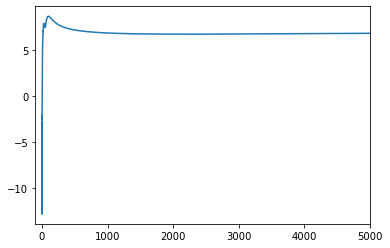

In [7]:
ellsc = 360*60/ell
plt.plot(ellsc, np.log(cl_cmb*norm))
plt.xlim(-100,5000)

In [8]:
%%time
alm_cmb = hp.synalm(cl_cmb, lmax=lmax)

CPU times: user 23.1 s, sys: 13.1 s, total: 36.3 s
Wall time: 45.4 s


In [9]:
%%time
map_cmb_256  = hp.alm2map(alm_cmb, nside=256,  lmax=lmax)
map_cmb_512  = hp.alm2map(alm_cmb, nside=512,  lmax=lmax)
map_cmb_1024 = hp.alm2map(alm_cmb, nside=1024, lmax=lmax)

CPU times: user 10min 53s, sys: 4.48 s, total: 10min 57s
Wall time: 2min 53s


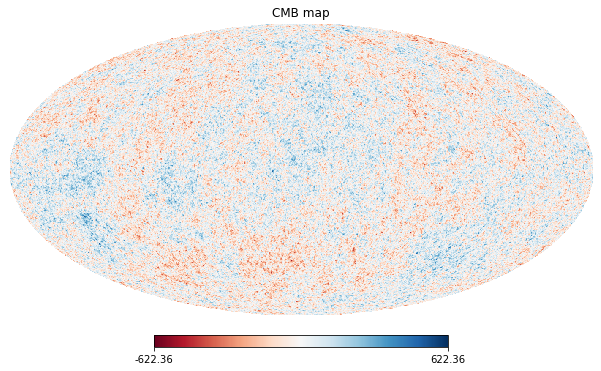

In [11]:
vmax = max(abs(map_cmb_1024.min()), abs(map_cmb_1024.max()))
hp.mollview(map_cmb_1024, min=-vmax, max=vmax, cmap=cmap, title="CMB map")

In [12]:
%%time
cl_cmb_out_256  = hp.anafast(map_cmb_256,  lmax=lmax, use_pixel_weights=True)
cl_cmb_out_512  = hp.anafast(map_cmb_512,  lmax=lmax, use_pixel_weights=True)
cl_cmb_out_1024 = hp.anafast(map_cmb_1024, lmax=lmax, use_pixel_weights=True)

CPU times: user 10min 18s, sys: 41 s, total: 10min 59s
Wall time: 4min 35s


<ipython-input-28-8a6aa9b87d3b>:2: RuntimeWarning: divide by zero encountered in true_divide
  ellsc = 360*60/ell
<ipython-input-28-8a6aa9b87d3b>:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(ellsc,np.log(dl_cmb))
<ipython-input-28-8a6aa9b87d3b>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(ellsc,np.log(dl_cmb))


(-100.0, 1200.0)

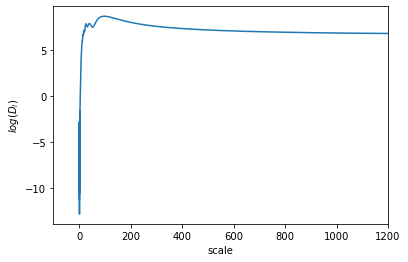

In [28]:
dl_cmb = cl_cmb*norm
ellsc = 360*60/ell
#ellsc=ellsc[::-1]
plt.plot(ellsc,np.log(dl_cmb))
plt.xlabel("scale")
plt.ylabel("$log(D_l)$")
plt.xlim (-100,1200)

In [16]:
resol_cmb_256 = hp.nside2resol(256, arcmin=False )
resol_cmb_512 = hp.nside2resol(512, arcmin=False )
resol_cmb_1024 = hp.nside2resol(1024, arcmin=False )
resol = resol_cmb_1024

In [21]:
jmax = 8
theta_bin = 10000
nside = 1024 

In [22]:
mor_l = s1.morlet_arr (resol, jmax , lmax, theta_bin)
gaus_l = s1.gaus_arr (resol, jmax, lmax, theta_bin)

/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1242: ComplexWarning: Casting complex values to real discards the imaginary part
  window[0] = trapz(beam * p0 * st, theta)
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1243: ComplexWarning: Casting complex values to real discards the imaginary part
  window[1] = trapz(beam * p1 * st, theta)
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1247: ComplexWarning: Casting complex values to real discards the imaginary part
  window[l] = trapz(beam * p2 * st, theta)


In [24]:
s1_cmb  ,i1_cmb= s1.compS1 (map_cmb_1024 , mor_l , gaus_l , resol, jmax, lmax , nside  )

0
1
2
3
4
5
6
7


Text(0, 0.5, 'log(S1)')

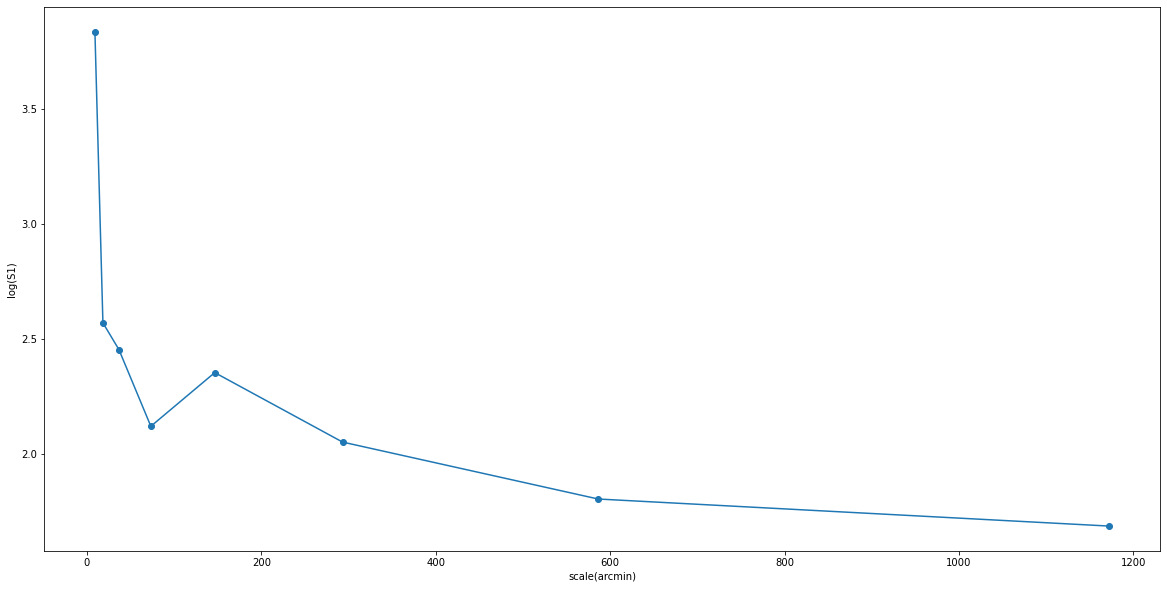

In [25]:
Jf=np.arange(jmax)
res1024_arcmin = hp.nside2resol(1024, arcmin=True)
scale=2**Jf*((2*res1024_arcmin)/0.75)
plt.figure(figsize=(20,10))
plt.plot (scale,np.log(s1_cmb),'o-')
plt.xlabel("scale(arcmin)")
plt.ylabel("log(S1)") 

In [33]:
s1_cmb_256 = compS1 (map_cmb_256 , resol_cmb_256, , lmax , 256 ,20000 )

0


/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1242: ComplexWarning: Casting complex values to real discards the imaginary part
  window[0] = trapz(beam * p0 * st, theta)
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1243: ComplexWarning: Casting complex values to real discards the imaginary part
  window[1] = trapz(beam * p1 * st, theta)
/Users/arefe/opt/anaconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:1247: ComplexWarning: Casting complex values to real discards the imaginary part
  window[l] = trapz(beam * p2 * st, theta)


1
2
3
4
5
6
7


Text(0, 0.5, '$log(Sl)$')

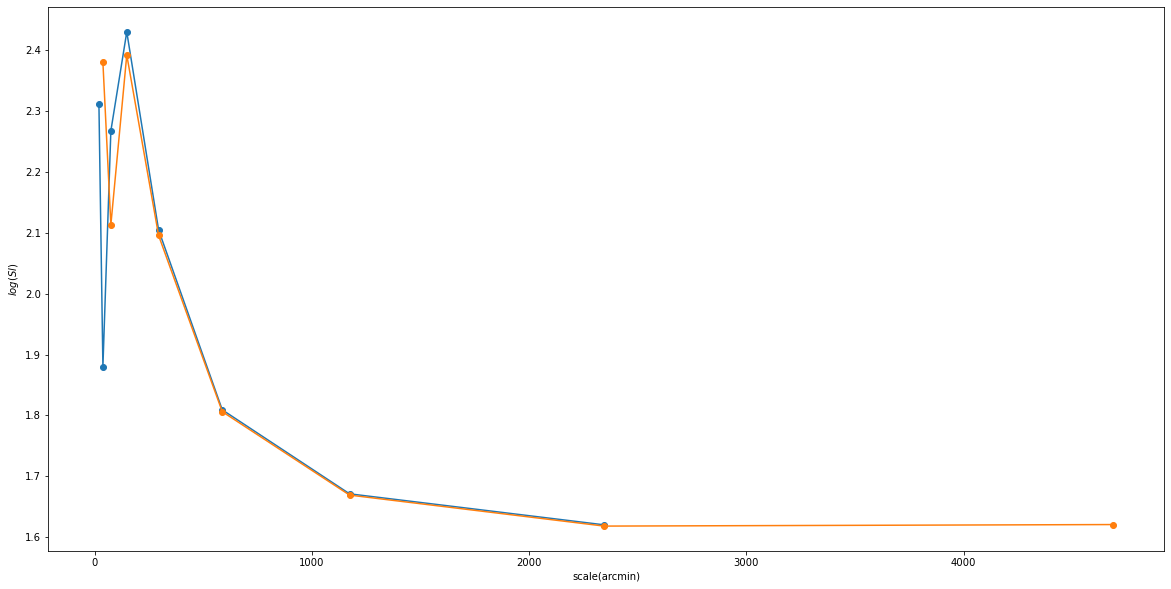

In [36]:
Jf=np.arange(8)
res512_arcmin = hp.nside2resol(512 , arcmin=True)
scale512=2**Jf*((2*res512_arcmin)/0.75)
scale256=2**Jf*((2*res256_arcmin)/0.75)
plt.figure(figsize=(20,10))
plt.plot (scale512,np.log(s1_cmb_512),'o-')
plt.plot (scale256,np.log(s1_cmb_256),'o-')
#plt.plot(ellsc,np.log(dl_sz))
#plt.legend(["dust map","regenerated dust map"])
plt.xlabel("scale(arcmin)")
plt.ylabel("$log(Sl)$")

In [67]:


def make_map(N,pix_size,ell,Dl): 
    "the pixel size (pix_size) required and the number N of pixels in the linear dimension."
    # convert Dl to Cl
    Cl = Dl * 2 * np.pi / (ell*(ell+1.))
    Cl[0] = 0. 
    Cl[1] = 0.

    # make a 2D real space coordinate system
    onesvec = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.) # create an array of size N between -0.5 and +0.5
    # compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
    # in range(N), which is just N rows copies of inds - for the x dimension
    X = np.outer(onesvec,inds) 
    # compute the transpose for the y dimension
    Y = np.transpose(X)
    # radial component R
    R = np.sqrt(X**2. + Y**2.)
    
    # now make a 2D CMB power spectrum
    pix_to_rad = (pix_size/60. * np.pi/180.) # going from pix_size in arcmins to degrees and then degrees to radians
    ell_scale_factor = 2. * np.pi /pix_to_rad  # now relating the angular size in radians to multipoles
    ell2d = R * ell_scale_factor # making a fourier space analogue to the real space R vector
    Cl_expanded = np.zeros(int(ell2d.max())+1)
    # making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D ell vector
    Cl_expanded[0:(Cl.size)] = Cl # fill in the Cls until the max of the Cl vector

    # the 2D Cl spectrum is defined on the multiple vector set by the pixel scale
    CL2d = Cl_expanded[ell2d.astype(int)]         
    
    # now make a realization of the given power spectrum in real space
    random_array = np.random.normal(0,1,(N,N))
    FT_random_array = np.fft.fft2(random_array) # take FFT since we are in Fourier space 
    
    FT_2d = np.sqrt(CL2d) * FT_random_array
    # plt.imshow(np.real(FT_2d))
    
    # move back from ell space to real space
    map_ = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
    # move back to pixel space for the map
    map_ = map_/(pix_size /60.* np.pi/180.)
    # we only want to plot the real component
    map_ = np.real(map_)

    ## return the map
    return(map_)
  ###############################

def Plot_Map(Map_to_Plot,X_width,Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    print("map mean:",np.mean(Map_to_Plot),"map rms:",np.std(Map_to_Plot))
    plt.gcf().set_size_inches(5, 5)
    im = plt.imshow(Map_to_Plot, interpolation=None, origin='lower',cmap=cm.YlOrBr)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    #cbar = plt.colorbar()
    im.set_extent([0,X_width,0,Y_width])
#     plt.ylabel('angle $[^\circ]$')
#     plt.xlabel('angle $[^\circ]$')
    
#     plt.savefig('cmbmap1.png',transparent=False)
    plt.show()
    
    return(0)
  ###############################

In [68]:


## variables to set up the size of the map
N = 2**9  # this is the number of pixels in a linear dimension
pix_size  = 2 # size of a pixel in arcminutes

X_width = N*pix_size/60.  # horizontal map width in degrees
Y_width = N*pix_size/60.  # vertical map width in degrees
 
seed = 100
np.random.seed(seed)

In [69]:
ell.shape

(20001,)

In [70]:
fmap_cmb = make_map (N, pix_size , ell , dl_cmb)

(7637,)


<ipython-input-67-abfd37540862>:4: RuntimeWarning: invalid value encountered in true_divide
  Cl = Dl * 2 * np.pi / (ell*(ell+1.))


ValueError: could not broadcast input array from shape (20001,) into shape (7637,)